In [2]:
import numpy as np
import scipy as sp
import math
from scipy.ndimage import interpolation
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

from time import time

# **Load Data**

In [ ]:
#download the 4 .gz data files, uncompress and put in folder data/

def read_data(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    f.close()
    l.close()
    df = pd.DataFrame(images)
    df.rename(columns = {0:'label'}, inplace = True) 
    return df

data_train = read_data("train-images.idx3-ubyte", "train-labels.idx1-ubyte",
        "mnist_train.csv", 60000)
data_test = read_data("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte",
        "mnist_test.csv", 10000)

In [20]:
X_train = data_train.drop(['label'], axis='columns', inplace=False)
Y_train = data_train['label']
X_test = data_test.drop(['label'], axis='columns', inplace=False)
Y_test = data_test['label']

# X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.25, 
#                                                     stratify=labels, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (60000, 784)
test feature shape:  (10000, 784)


Class distribution:

In [21]:
data_train['label'].value_counts(normalize=True) * 100

1    11.236667
7    10.441667
3    10.218333
2     9.930000
9     9.915000
0     9.871667
6     9.863333
8     9.751667
4     9.736667
5     9.035000
Name: label, dtype: float64

Visulisation of the data:

In [1]:
def plot_number(row, w=28, h=28):
    label = row['label']
    pixels = row[1:]

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')


def plot_slice(rows, size_w=28, size_h=28):
    num = rows.shape[0]
    w = 4
    h = math.ceil(num / w)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_number(rows.iloc[n], size_w, size_h)
    plt.show()
    
plot_slice(data_train[0:12])

NameError: name 'data_train' is not defined

Deskew the images:

In [83]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

def deskew_vectorize(images):
    """Deskew matrix of N MNIST sample
    :images: Matrix size (N, 784)
    :returns: Matrix size (N, 28, 28)
    """
    N = images.shape[0]
    reshaped_images = images.reshape(N , 28, 28)
    deskewed_images = np.array(list(map(deskew, reshaped_images)))

    return deskewed_images.reshape(N, 784)

X_train = deskew_vectorize(X_train.values)
X_test = deskew_vectorize(X_test.values)

# **HOG**

In [ ]:
def calculate_hog_features(images):
    list_hog_fd = [hog(t.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1),
                       visualise=False) for t in images]
    return np.array(list_hog_fd, dtype=np.float64)

train_hog_features = calculate_hog_features(train_images)

# **PCA**

Use MinMaxScaler to standardize the data:

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
https://www.quora.com/Which-advantages-does-MinMax-scaling-have-over-a-standard-scaling-using-the-mean-and-the-standard-deviation

Compare MinMaxScaler to StandardScaler?

In [84]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

First visualize by choosing only 2 components:

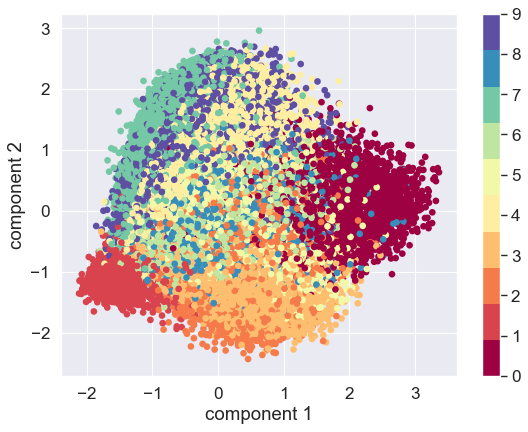

In [85]:
figure(num=None, figsize=(8, 6), dpi=80)

n_components = 2
pca = PCA(n_components=n_components,
          whiten=True).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
            c=Y_train, edgecolor='none',
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

plt.savefig('foo.png')

Now we decide the number of components:

In [86]:
n_components = 784
pca = PCA(n_components=n_components)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
print(pca.n_components_)

var=np.cumsum(pca.explained_variance_ratio_*100)

784


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


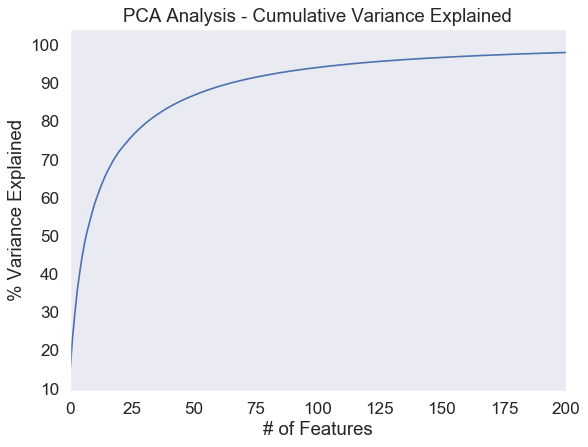

In [88]:
figure(num=None, figsize=(8, 6), dpi=80)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - Cumulative Variance Explained')
plt.xlim(0,200)
plt.yticks(np.arange(0, 100.5, step=10))
plt.style.context('seaborn-whitegrid')
ax = plt.axes()
ax.grid()
plt.plot(var);

In [89]:
n_components = 50
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

# **SVM**

In [90]:
import warnings
warnings.filterwarnings("ignore")

param_grid = { "C" : [1, 2, 5]
              , "gamma" : [0.01, 0.02, 0.05, 0.1]}

# param_grid = { "C" : [5]
#               , "gamma" : [0.05]}
t0 = time()
rf = SVC()
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_train_pca, Y_train)
print("done in %0.3fs" % (time() - t0))

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 18.3min finished


done in 1151.862s
0.9870333333333333
{'C': 5, 'gamma': 0.02}


In [91]:
bp = gs.best_params_

t0 = time()
clf = SVC(C=bp['C'], kernel='rbf', gamma=bp['gamma'])
clf = clf.fit(X_train_pca, Y_train)
print("done in %0.3fs" % (time() - t0))

done in 61.166s


In [92]:
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
Y_predict= clf.predict(pca.transform(X_test_scaled))
clf.score(pca.transform(X_test_scaled), Y_test)

0.989

Confusion matrix:

Confusion matrix, without normalization
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1129    2    0    0    1    2    1    0    0]
 [   1    1 1019    2    2    0    1    3    3    0]
 [   0    0    3 1001    0    2    0    0    4    0]
 [   0    0    2    0  972    0    3    0    1    4]
 [   1    0    0    3    0  885    2    0    1    0]
 [   3    3    0    1    2    4  943    1    1    0]
 [   0    0    6    0    2    2    0 1016    0    2]
 [   2    0    1    3    0    1    0    2  963    2]
 [   0    1    1    5    7    4    1    4    2  984]]
Confusion matrix, without normalization
AxesSubplot(0.0832031,0.0335069;0.718437x0.947743)


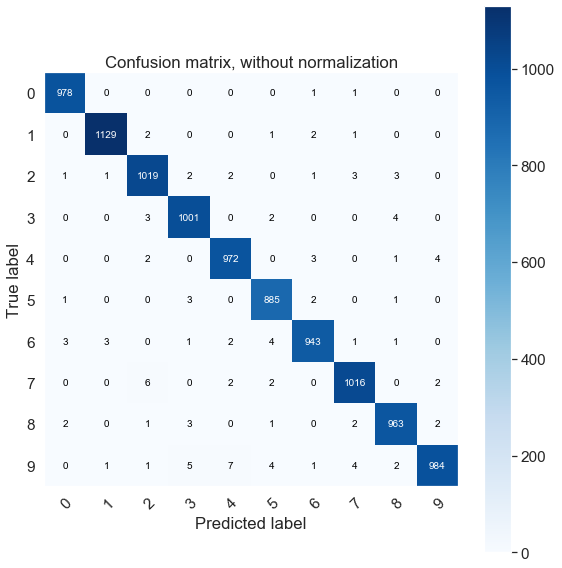

In [94]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(None) 
    plt.rcParams["figure.figsize"] = (10,10)
    return ax

np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(Y_test, Y_predict, clf.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

    print(title)
    print(disp)
    
plt.show();